In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
from scipy.optimize import curve_fit
%matplotlib inline

matplotlib.pylab.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
data1 = np.loadtxt("data/cam37_asteroid_objects_unsorted.dat")
data2 = np.loadtxt("data/cam5_asteroid_objects_unsorted.dat")

data1 = np.sort(data1, axis=0)
data2 = np.sort(data2, axis=0)

In [3]:
t1 = data1[:,0]
ra1 = data1[:,1]
dec1 = data1[:,2]

t2 = data2[:,0]
ra2 = data2[:,1]
dec2 = data2[:,2]

In [4]:
# Belichtungszeitkorrektur
t1 = t1 + 5
t2 = t2 + 5

In [5]:
f = lambda x, a, b, c: a*x**2 + b*x + c

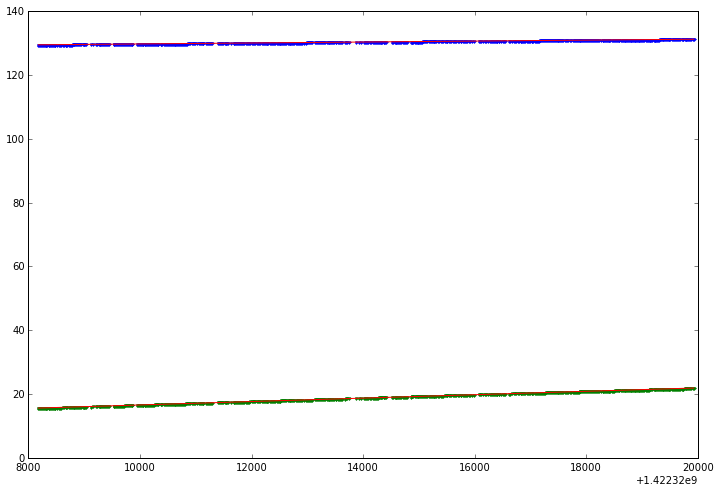

In [6]:
plt.plot(t1, ra1, '.')
plt.plot(t1, dec1, '.')

popt_ra1, pcov_ra1 = curve_fit(f, t1, ra1)
popt_dec1, pcov2_dec1 = curve_fit(f, t1, dec1)

plt.plot(t1, f(t1, *popt_ra1), 'r-')
plt.plot(t1, f(t1, *popt_dec1), 'r-')

plt.show()

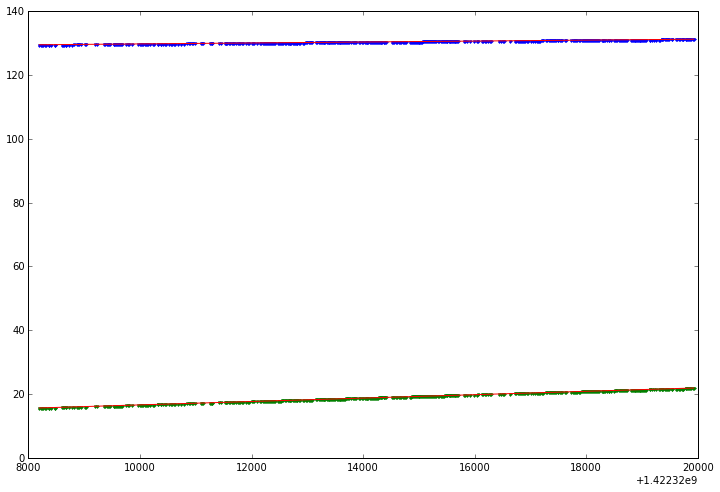

In [7]:
plt.plot(t2, ra2,'.')
plt.plot(t2, dec2,'.')

popt_ra2, pcov_ra2 = curve_fit(f, t2, ra2)
popt_dec2, pcov_dec2 = curve_fit(f, t2, dec2)

plt.plot(t2, f(t2, *popt_ra2), 'r-')
plt.plot(t2, f(t2, *popt_dec2), 'r-')

plt.show()

# Umrechnung der Koordinaten

In [8]:
from astropy import units as u
from poliastro.bodies import Sun
from poliastro.twobody import State

In [9]:
def earth_nu(t):
    return 23.45 + 0.14 / 11700.0 * (t - 1422334020)

Mittlere Kepler-Elemente auf Äquinoktium J2000.0: wikipedia Erdbahn

In [10]:
T = (2457049.7 - 2451545) / 36525

In [11]:
def earth_pos(t):
    nu = earth_nu(t)
    earth = {'a': 1.00000 * u.AU,
             'ecc': (0.016709 - 0.000042 * T) * u.one,
             'inc': (0.0131 * T) * u.deg,
             'raan': (174.876 - 0.242 * T) * u.deg,
             'argp': (102.94 + 0.3222 * T) * u.deg,
             'nu': nu * u.deg}
    
    earth_state = State.from_elements(Sun, earth['a'], earth['ecc'],
                                      earth['inc'], earth['raan'],
                                      earth['argp'], earth['nu'])
    
    return (earth_state.r.si.value, earth_state.v.si.value)

In [12]:
def angles(r, t):
    epos, _ = earth_pos(t)
    r = r - epos
    
    e = np.deg2rad(23.4) 
    M = np.array([[1, 0, 0],
                 [0, np.cos(e), -np.sin(e)],
                 [0, np.sin(e), np.cos(e)]])
    r_eq = np.dot(M, r)
    
    ra = np.arctan2(r[1], r[0])
    dec = np.arctan2(r[2] , np.sqrt(r[0]**2 + r[1]**2))
    
    return ra, dec

In [13]:
from scipy.optimize import minimize

In [14]:
def propagate(t, r, v):
    r_arr = np.array([r])
    v_arr = np.array([v])
    
    state = State.from_vectors(Sun, r * u.m, v * u.m / u.s)
    
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        
        state = state.propagate(dt * u.s)
        
        r_arr = np.concatenate((r_arr, np.array([state.r.si.value])), axis=0)
        v_arr = np.concatenate((v_arr, np.array([state.v.si.value])), axis=0)
        
    return r_arr, v_arr

In [15]:
def chi_ra_sq(t, r, v, data):
    # State propagieren
    r_arr,v_arr = propagate(t, r, v)
    
    total = 0
    for i in range(len(t)):
        ra, dec = angles(r_arr[i], t[i])
        
        resid = ra - data[i,1]
        
        total += resid**2
    
    return total

def chi_dec_sq(t, r, v, data):
    # State propagieren
    r_arr,v_arr = propagate(t, r, v)
    
    total = 0
    for i in range(len(t)):
        ra, dec = angles(r_arr[i], t[i])
        
        resid = dec - data[i,2]
        
        total += resid**2
    
    return total

def wrap_ra(rv):
    return chi_ra_sq(t1, rv[:3], rv[3:], data1)

def wrap_dec(rv):
    return chi_dec_sq(t1, rv[:3], rv[3:], data1)

In [16]:
bl86 = State.from_elements(Sun, 1.502 * u.AU, 0.403 * u.one, 23.744 * u.deg, 126.72 * u.deg, 311.255 * u.deg, 122 * u.deg)

In [17]:
#propagate(t, np.array([-2.094E11, -70152612000, 92272335000]), np.array([-397.46751, -21983.36, 5921.984]))

In [18]:
guess = np.array([-2E11, -70152000000, 92270005000, -396.46751, -21950.36, 5900.984])
result_ra = minimize(wrap_ra, guess)

In [19]:
guess = result_ra.x
result_dec = minimize(wrap_dec, guess)

In [20]:
result_dec

  success: True
  message: 'Optimization terminated successfully.'
        x: array([ -2.00000000e+11,  -7.01520000e+10,   9.22700050e+10,
        -3.96467510e+02,  -2.19503600e+04,   5.90098400e+03])
      jac: array([ 0.,  0.,  0.,  0.,  0.,  0.])
   status: 0
     nfev: 8
     njev: 1
      fun: 198673.62718815883
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])